#Fish2Eat Model - Capstone Project

####Objective: To classify fish species from images and provide recipes, nutritional information, and food pairing suggestions.

####Target Accuracy: Achieve at least 75% accuracy in identifying fish species.

# Import libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import imghdr
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from google.colab import files

#Step 1: Access Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/capstone/dataset.zip" -d "/content/dataset"

In [ ]:
!ls /content/dataset/dataset

train  validation


In [ ]:
base_dir = "/content/dataset/dataset"

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

In [ ]:
os.listdir(train_dir)

['Nila',
 'Lele',
 'Tongkol',
 'Tuna',
 'Gurame',
 'Patin',
 'Teri',
 'Sapu-sapu',
 'Salmon',
 'Mujair',
 'Tenggiri',
 'Bandeng',
 'Gabus',
 'Sarden',
 'Kakap Merah']

In [ ]:
os.listdir(valid_dir)

['Nila',
 'Lele',
 'Tongkol',
 'Tuna',
 'Gurame',
 'Patin',
 'Teri',
 'Sapu-sapu',
 'Salmon',
 'Mujair',
 'Tenggiri',
 'Bandeng',
 'Gabus',
 'Sarden',
 'Kakap Merah']

#Step 2: Clean Dataset

In [ ]:
image_extensions = [".png", ".jpg"]
img_type_supported_tensorflow = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(base_dir).rglob("*"):
    if filepath.is_file():
        if filepath.suffix.lower() in image_extensions:
            img_type = imghdr.what(filepath)
            if img_type is None or img_type not in img_type_supported_tensorflow:
                print(f"{filepath} is not valid, delete this image.")
                os.remove(filepath)
        else:
            print(f"{filepath} has an invalid file extension, delete this image.")
            os.remove(filepath)

#Step 3: Load Dataset

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 500
BATCH_SIZE = 128
IMG_SIZE = (128, 128)
NUM_CLASSES = 15

In [ ]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    valid_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

Found 15406 files belonging to 15 classes.
Found 3702 files belonging to 15 classes.


#Step 4: Data Augmentation

In [ ]:
@tf.function
def augment(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

train_dataset = (train_dataset
    .map(augment)
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

validation_dataset = (validation_dataset
    .map(lambda x, y: (x / 255.0, y))
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

#Step 5: Define CNN Model

In [ ]:
model = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.5),
    Dense(15, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,625,359 (10.01 MB)

 Trainable params: 2,625,359 (10.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = Adam(learning_rate=1e-4),
          loss = 'categorical_crossentropy',
          metrics = ['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

#Step 6: Train the Model


In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 162s 376ms/step - accuracy: 0.1140 - loss: 2.7840 - val_accuracy: 0.3809 - val_loss: 2.1875 - learning_rate: 1.0000e-04
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.3140 - loss: 2.2353 - val_accuracy: 0.4571 - val_loss: 1.8612 - learning_rate: 1.0000e-04
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.4182 - loss: 1.9074 - val_accuracy: 0.5497 - val_loss: 1.5619 - learning_rate: 1.0000e-04
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5078 - loss: 1.6558 - val_accuracy: 0.6148 - val_loss: 1.3660 - learning_rate: 1.0000e-04
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5590 - loss: 1.5129 - val_accuracy: 0.6310 - val_loss: 1.2978 - learning_rate: 1.0000e-04
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.6018 - loss: 1.3831 - val_accuracy: 0.6829 - val_loss: 1.1655 - learning_rate: 1.0000e-04
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step

#Step 7: Visualization

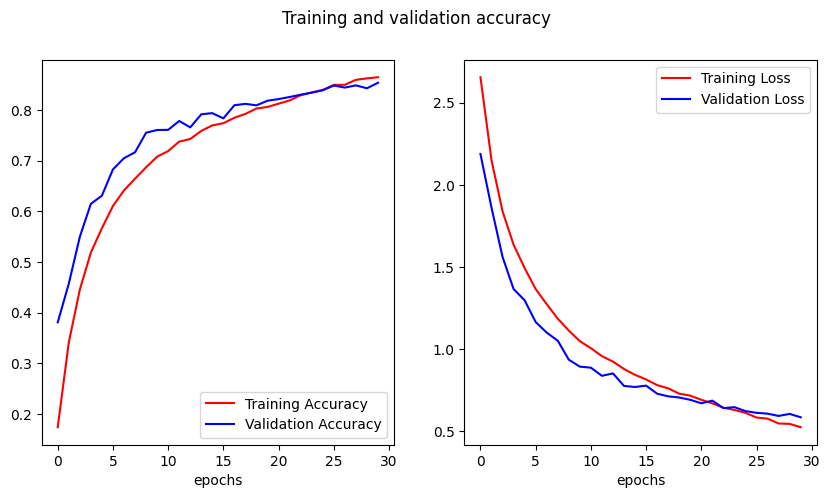

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

#Step 8: Save and Download Model

In [ ]:
model.save('fish2eat_model.h5')
files.download('fish2eat_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Step 9: Save and Download Labels

In [ ]:
import json

class_labels = {
    0: 'Bandeng',
    1: 'Gabus',
    2: 'Gurame',
    3: 'Kakap Merah',
    4: 'Lele',
    5: 'Mujair',
    6: 'Nila',
    7: 'Patin',
    8: 'Salmon',
    9: 'Sapu-sapu',
    10: 'Sarden',
    11: 'Tenggiri',
    12: 'Teri',
    13: 'Tongkol',
    14: 'Tuna'
}

with open('labels.json', 'w') as f:
    json.dump(class_labels, f)
files.download('labels.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Step 10: Predict and Display an Image

Upload an image to predict its class:


Saving tongkol.jpg to tongkol.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted class for tongkol.jpg: Tongkol (93.32% confidence)


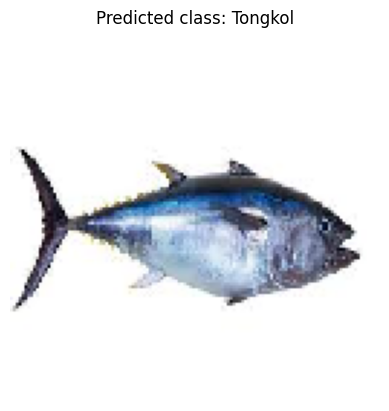

In [ ]:
def predict_upload_image(model, target_size=(150, 150)):
    print("Upload an image to predict its class:")
    uploaded = files.upload()

    for fn in uploaded.keys():

        path = fn

        img = load_img(path, target_size=target_size)
        x = img_to_array(img)
        x /= 255.0
        x = np.expand_dims(x, axis=0)

        predictions = model.predict(x)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]
        predicted_class_label = class_labels[predicted_class]

        print(f"Predicted class for {fn}: {class_labels[predicted_class]} ({confidence*100:.2f}% confidence)")
        plt.imshow(img)
        plt.title(f"Predicted class: {predicted_class_label}")
        plt.axis('off')
        plt.show()


predict_upload_image(model, target_size=IMG_SIZE)